In [1]:
import pandas as pd
csv_path = "Data\jena_climate_2009_2016.csv"
data_frame = pd.read_csv(csv_path)

In [2]:
time = data_frame['Date Time']
temperature = data_frame['T (degC)']
pressure = data_frame['p (mbar)']
relative_humidity = data_frame['rh (%)']
vapor_pressure = data_frame['VPact (mbar)']
wind_speed = data_frame['wv (m/s)']
airtight = data_frame['rho (g/m**3)']

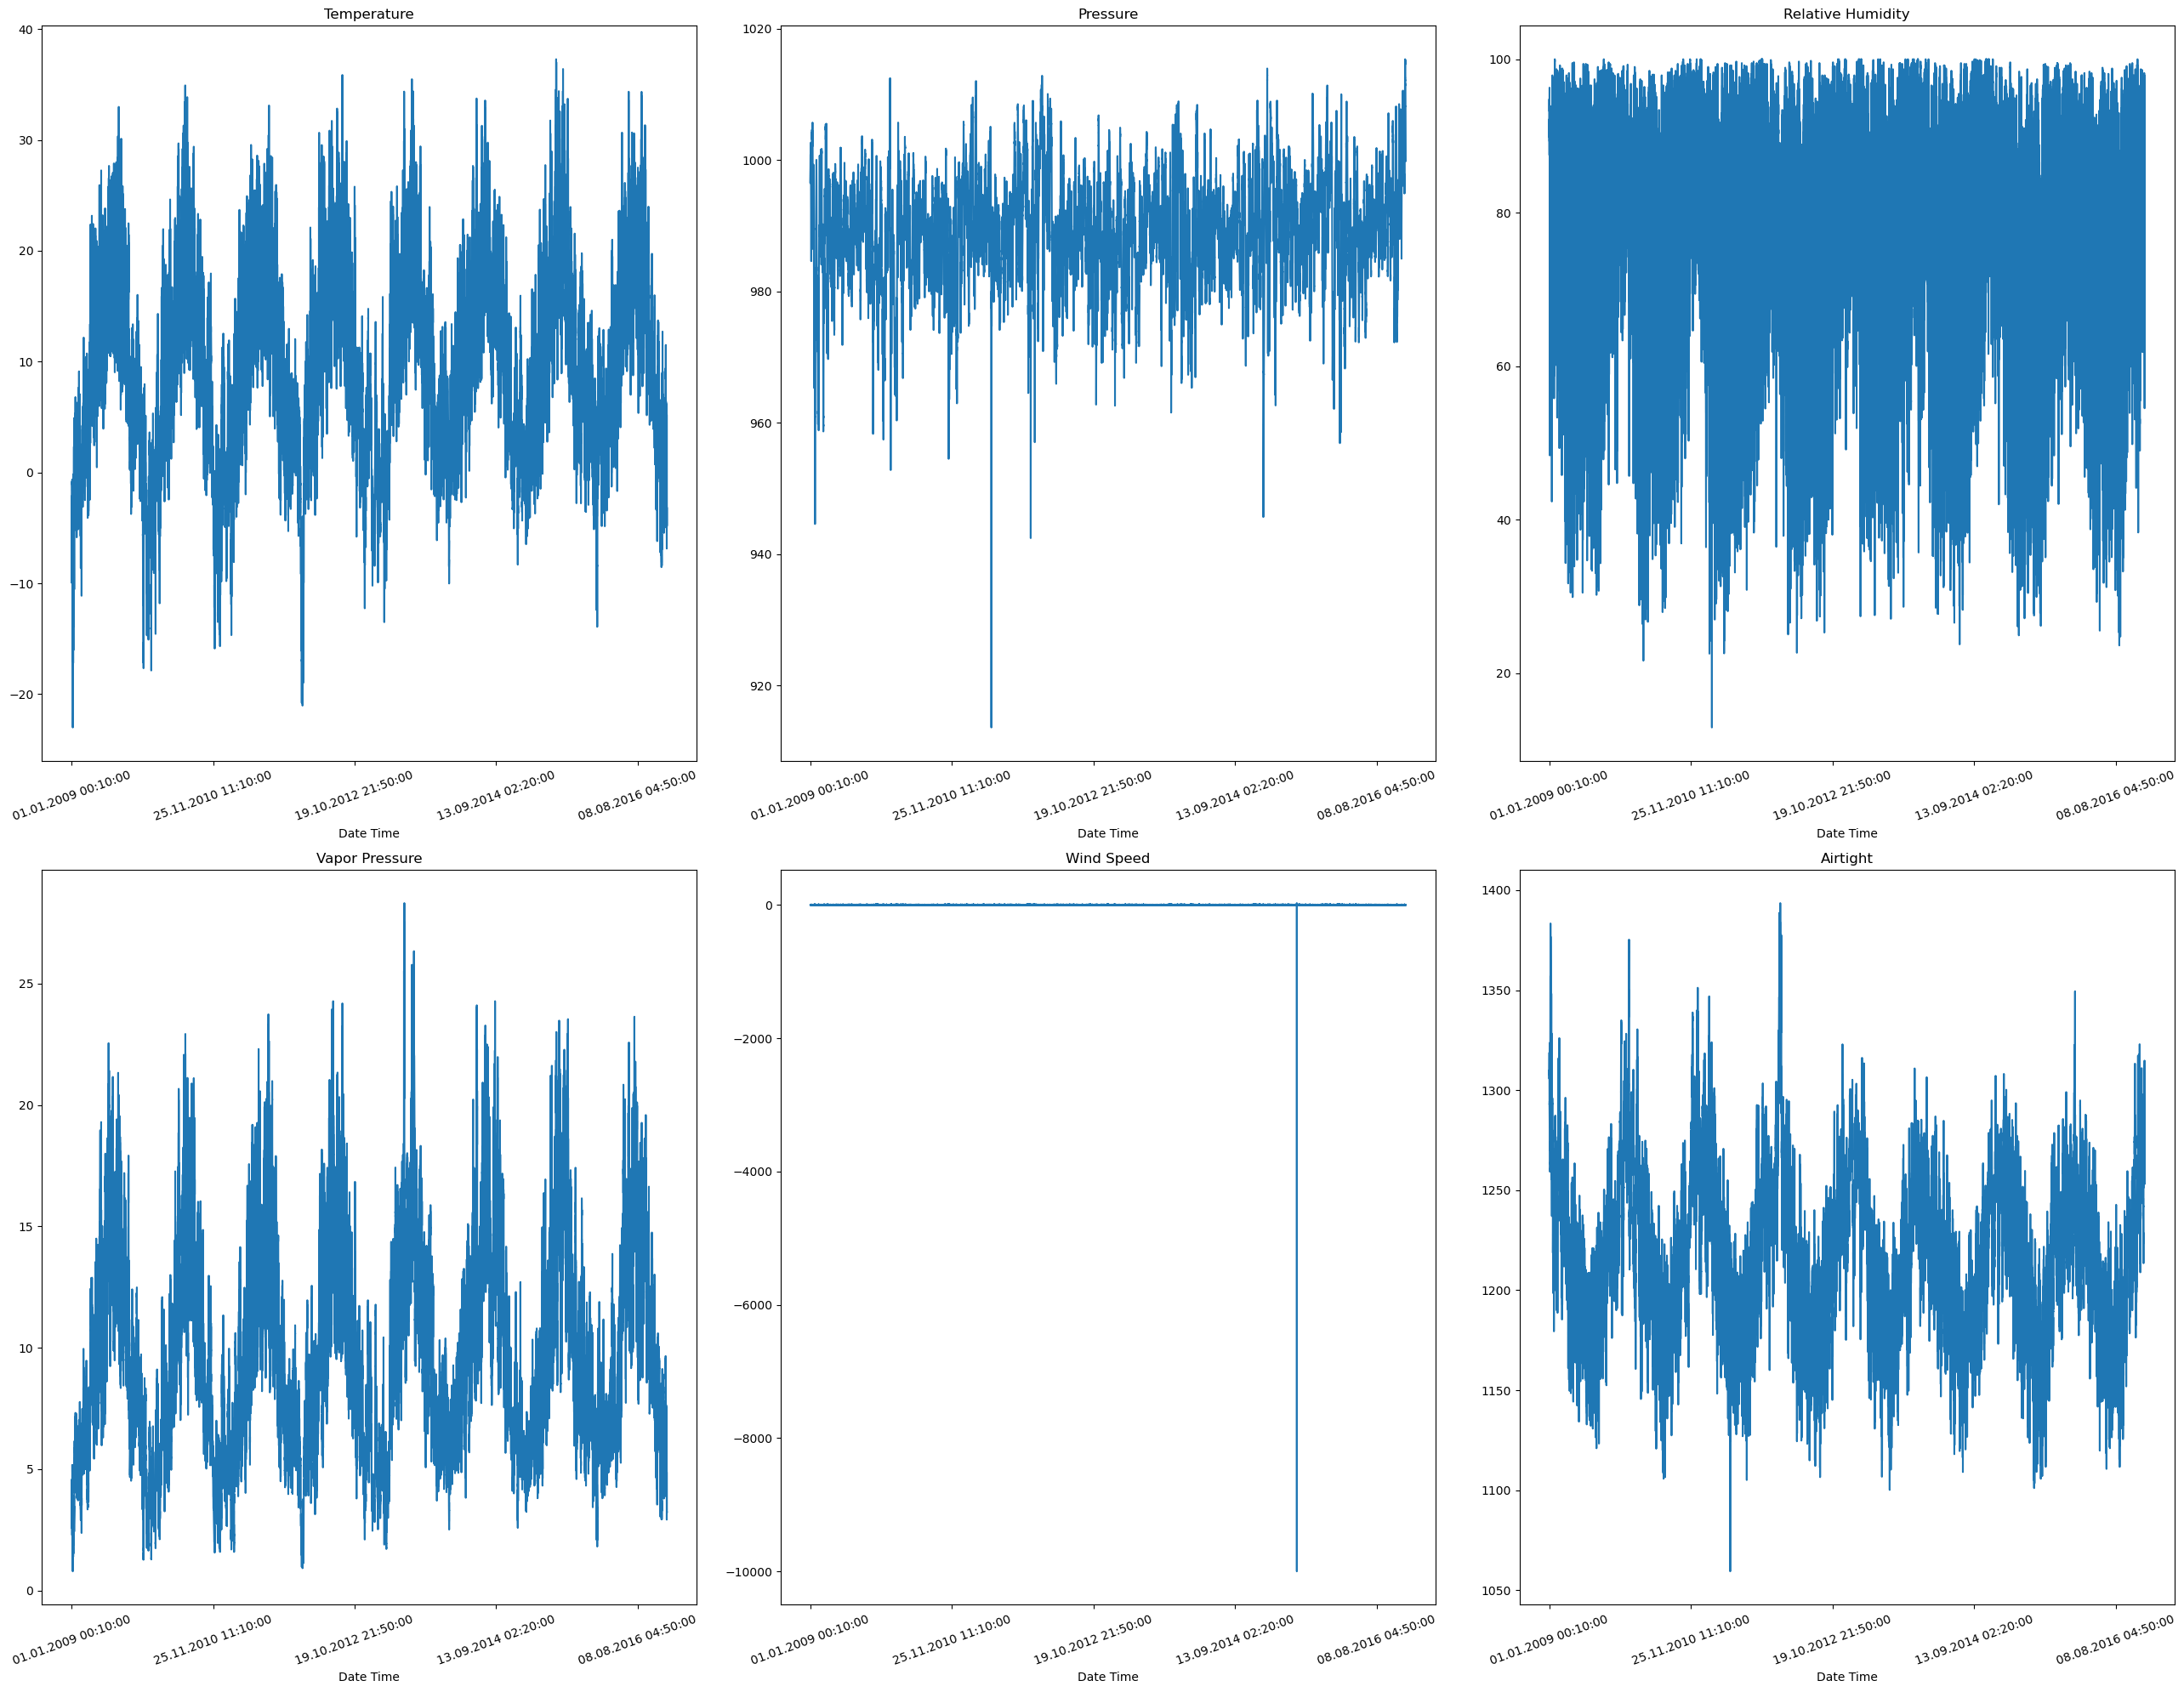

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

ax = plt.subplot(2, 3, 1)
temperature.index = time
temperature.head()
temperature.plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 3, 2)
pressure.index = time
pressure.head()
pressure.plot(rot=20)
plt.title('Pressure')

ax = plt.subplot(2, 3, 3)
relative_humidity.index = time
relative_humidity.head()
relative_humidity.plot(rot=20)
plt.title('Relative Humidity')

ax = plt.subplot(2, 3, 4)
vapor_pressure.index = time
vapor_pressure.head()
vapor_pressure.plot(rot=20)
plt.title('Vapor Pressure')

ax = plt.subplot(2, 3, 5)
wind_speed.index = time
wind_speed.head()
wind_speed.plot(rot=20)
plt.title('Wind Speed')

ax = plt.subplot(2, 3, 6)
airtight.index = time
airtight.head()
airtight.plot(rot=20)
plt.title('Airtight')

plt.tight_layout()
plt.show()

In [4]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [9]:
features = pd.concat([temperature, pressure, relative_humidity, vapor_pressure, wind_speed, airtight], axis=1)
features.index = time
features

,T (degC),p (mbar),rh (%),VPact (mbar),wv (m/s),rho (g/m**3)
Date Time,,,,,,
01.01.2009 00:10:00,-8.02,996.52,93.30,3.11,1.03,1307.75
01.01.2009 00:20:00,-8.41,996.57,93.40,3.02,0.72,1309.80
01.01.2009 00:30:00,-8.51,996.53,93.90,3.01,0.19,1310.24
01.01.2009 00:40:00,-8.31,996.51,94.20,3.07,0.34,1309.19
01.01.2009 00:50:00,-8.27,996.51,94.10,3.08,0.32,1309.00
...,...,...,...,...,...,...
31.12.2016 23:20:00,-4.05,1000.07,73.10,3.30,0.67,1292.98
31.12.2016 23:30:00,-3.35,999.93,69.71,3.32,1.14,1289.44
31.12.2016 23:40:00,-3.16,999.82,67.91,3.28,1.08,1288.39


In [10]:
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2,3,4,5
0,-2.074013,0.874230,1.049501,-1.535256,-0.010271,2.293606
1,-2.120313,0.880212,1.055570,-1.556766,-0.015008,2.344887
2,-2.132184,0.875426,1.085917,-1.559156,-0.023106,2.355894
3,-2.108441,0.873033,1.104125,-1.544816,-0.020814,2.329628
4,-2.103692,0.873033,1.098056,-1.542426,-0.021120,2.324875
...,...,...,...,...,...,...
420546,-1.602704,1.298949,-0.176513,-1.489847,-0.015772,1.924126
420547,-1.519602,1.282199,-0.382265,-1.485067,-0.008591,1.835571
420548,-1.497046,1.269039,-0.491514,-1.494627,-0.009507,1.809305
420549,-1.624073,1.267842,-0.255415,-1.513746,-0.003243,1.938635


In [11]:
training_size = int ( 0.8 * features.shape[0])  
train_data = features.loc[0 : training_size - 1]
val_data = features.loc[training_size:]

In [12]:
start = 432 + 36
end = start + training_size

x_train = train_data.values
y_train = features.iloc[start:end][[0]]

sequence_length = int(432 / 6)

In [13]:
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [14]:
x_val_end = len(val_data) - start

label_start = training_size + start

x_val = val_data.iloc[:x_val_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [15]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "Weather_forcaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 72, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

Epoch 1/15
2120/5251 ━━━━━━━━━━━━━━━━━━━━ 1:46 34ms/step - loss: 0.2914

KeyboardInterrupt: 

In [ ]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

for x, y in dataset_val.skip(12):
    history_data = x[0][:, 1].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(36, true_value, "gD")
    plt.plot(36, prediction, "rX")
    plt.legend(["History", "True Future", "Model Prediction"])
    plt.xlabel("Time")
    plt.show()
    break